In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *


In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [3]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [4]:
reflectance_files_april09, radiance_files_VNIR_april09, radiance_files_SWIR_april09

(['../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163351_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163915_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_164414_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_171839_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_172333_reflectance.h5'],
 ['../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S2',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S3',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S4',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S5'],
 ['../headwall_data/SWIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../hea

In [5]:
## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=1
data_file_VNIR = radiance_files_VNIR_april09[hw_ind]
data_file_SWIR = radiance_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)

NEON ID:  R10C
../headwall_data/VNIR/TableMtn_Flight1_processed\TM_F1_S2


In [6]:
## read the data into xarray datasets, chunk with Dask
# first Headwall
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

In [7]:
# then NEON (dask chunking done in-function)
x_neon_atcor, y_neon_atcor, xarr_NEON_atcor = NEON_create_refl_xarr_from_h5_file(data_file_NEON, nid=neon_id)

# read the elm corrected data
# data_file_NEON = r"D:\projects\headwall_neon\atcor_aois\elm\test_20190409_163351_radiance_elm.hdr"
# xarr_NEON = xr.open_rasterio(data_file_NEON, chunks=(256, 256, 256), driver='ENVI')

data_file_NEON = r"D:\projects\headwall_neon\atcor_aois\elm\test_20190409_163351_radiance_elm_BSQ"
xarr_NEON = xr.open_rasterio(data_file_NEON, chunks=(256, 256, 256))
x_neon, y_neon = xarr_NEON.coords['x'].values, xarr_NEON.coords['y'].values

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [8]:
x_neon, y_neon

(array([478768.5, 478769.5, 478770.5, 478771.5, 478772.5, 478773.5,
        478774.5, 478775.5, 478776.5, 478777.5, 478778.5, 478779.5,
        478780.5, 478781.5, 478782.5, 478783.5, 478784.5, 478785.5,
        478786.5, 478787.5, 478788.5, 478789.5, 478790.5, 478791.5,
        478792.5, 478793.5, 478794.5, 478795.5, 478796.5, 478797.5,
        478798.5, 478799.5, 478800.5, 478801.5, 478802.5, 478803.5,
        478804.5, 478805.5, 478806.5, 478807.5, 478808.5, 478809.5,
        478810.5, 478811.5, 478812.5, 478813.5, 478814.5, 478815.5,
        478816.5, 478817.5, 478818.5, 478819.5, 478820.5, 478821.5,
        478822.5, 478823.5, 478824.5, 478825.5, 478826.5, 478827.5,
        478828.5, 478829.5, 478830.5, 478831.5, 478832.5, 478833.5,
        478834.5, 478835.5, 478836.5, 478837.5, 478838.5, 478839.5,
        478840.5, 478841.5, 478842.5, 478843.5, 478844.5, 478845.5,
        478846.5, 478847.5, 478848.5, 478849.5, 478850.5, 478851.5,
        478852.5, 478853.5, 478854.5, 478855.5, 

# Spatial extraction

In [9]:
buffer_dist = 3 # meters

## use the shapefile
pt_index = 0
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [10]:
xarr_NEON.coords

Coordinates:
  * band        (band) int32 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426
  * y           (y) float64 4.445e+06 4.445e+06 ... 4.439e+06 4.439e+06
  * x           (x) float64 4.788e+05 4.788e+05 ... 4.795e+05 4.795e+05
    fwhm        (band) float64 dask.array<shape=(426,), chunksize=(256,)>
    wavelength  (band) float64 dask.array<shape=(426,), chunksize=(256,)>

In [11]:
## do the extraction
neon_sub_cube_atcor, neon_arrs_atcor = extract_from_NEON((xarr_NEON_atcor, x_neon_atcor, y_neon_atcor), pt_df_neon)
neon_sub_cube, neon_arrs = extract_from_NEON_ENVI((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall((xarr_VNIR, x_vnir, y_vnir), 
                                                            (xarr_SWIR, x_swir, y_swir),
                                                            pt_df_hw)

neon_wav_atcor, full_neon_atcor = neon_arrs_atcor
neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

(64, 65, 270) (65, 65, 270)
(64, 65, 270) (64, 65, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:169: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


# plot mean of both systems

In [12]:
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

neon_mean_atcor = np.nanmean(full_neon_atcor, axis=1)
neon_max_atcor = np.nanmax(full_neon_atcor, axis=1)
neon_min_atcor = np.nanmin(full_neon_atcor, axis=1)

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


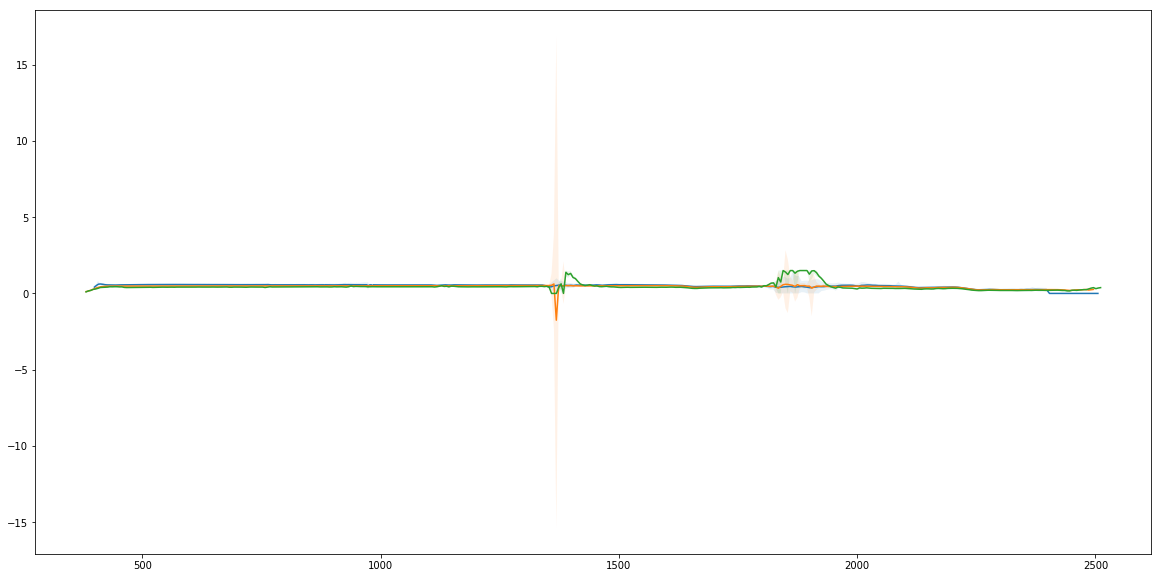

In [13]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean)
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)
plt.plot(neon_wav, neon_mean)
plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
plt.plot(neon_wav_atcor, neon_mean_atcor)
plt.fill_between(neon_wav_atcor, neon_min_atcor, neon_max_atcor, alpha=0.1)
plt.show()

In [14]:
## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_neon_atcor = np.where(((neon_wav_atcor > 1260) & (neon_wav_atcor < 1560)) | ((neon_wav_atcor > 1760) & (neon_wav_atcor < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))

In [15]:
hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

neon_mean_ma_atcor = neon_mean_atcor.copy()
neon_mean_ma_atcor[bad_neon_atcor] = np.nan
neon_max_ma_atcor = neon_max_atcor.copy()
neon_max_ma_atcor[bad_neon_atcor] = np.nan
neon_min_ma_atcor = neon_min_atcor.copy()
neon_min_ma_atcor[bad_neon_atcor] = np.nan

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


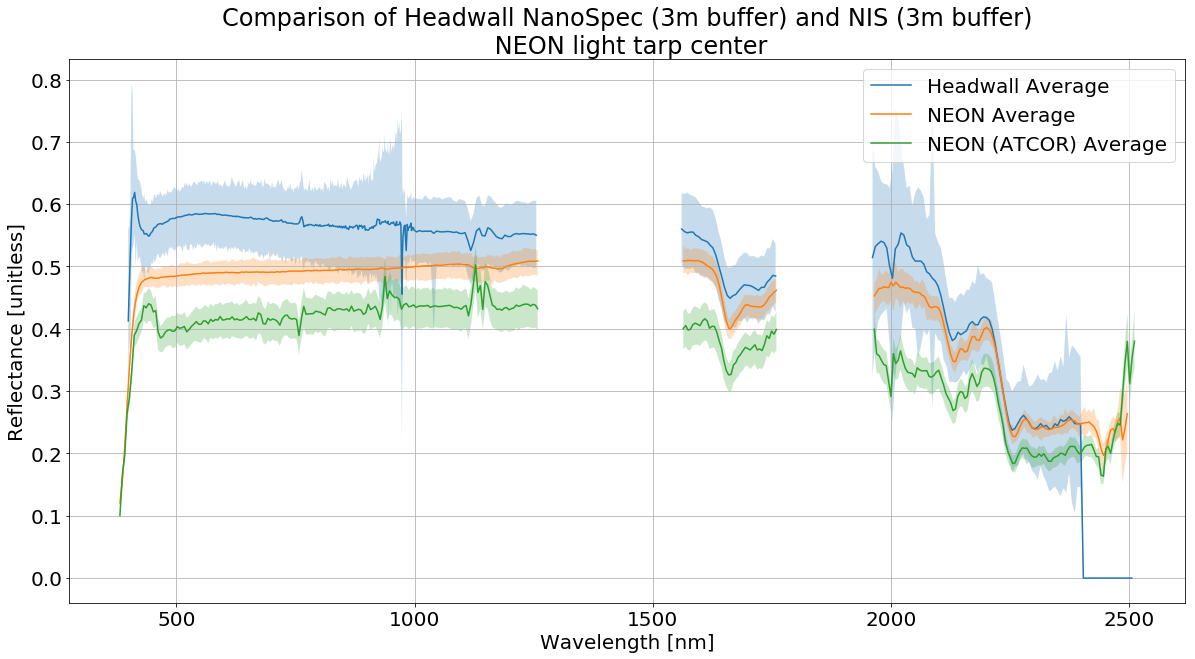

In [16]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)
plt.plot(neon_wav_atcor, neon_mean_ma_atcor, label='NEON (ATCOR) Average')
plt.fill_between(neon_wav_atcor, neon_min_ma_atcor, neon_max_ma_atcor, alpha=0.25)

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

# load the ASD for the white tarp

In [17]:
asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp1/0048WhiteTarp1_refl.spectra"
asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp2/0048WhiteTarp2_refl.spectra"
asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')


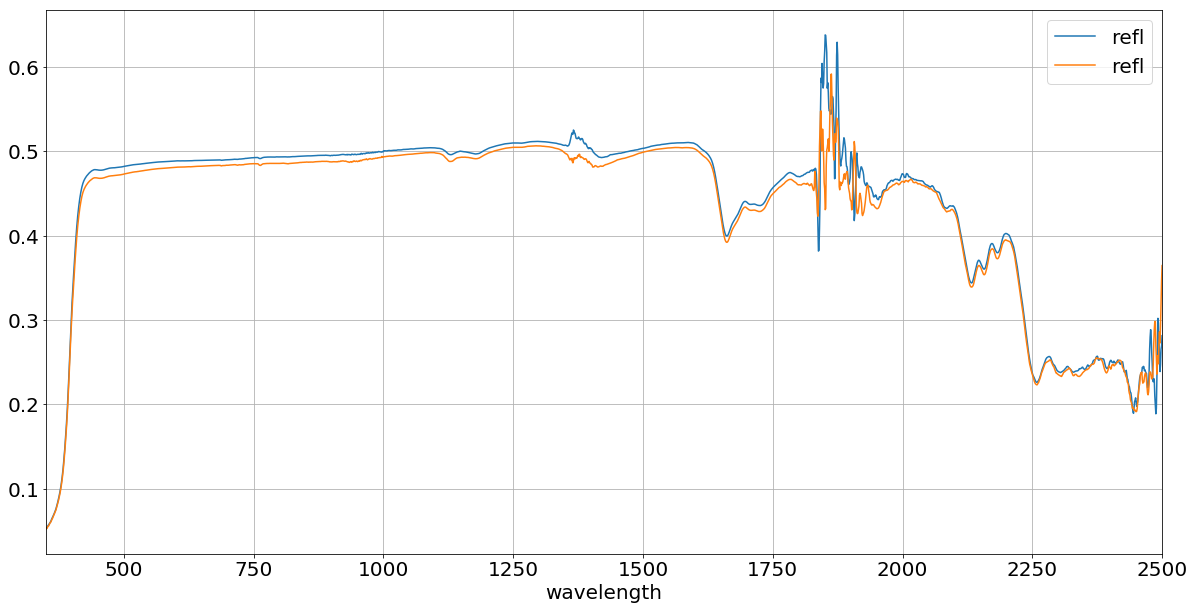

In [18]:
ax = asd1.plot(x='wavelength', y='refl', figsize=(20,10), grid=True)
asd2.plot(x='wavelength', y='refl', figsize=(20,10), grid=True, ax=ax)

# they are pretty close, so just use the first one

In [19]:
## mask the water vapor features
asd_wav = asd1.wavelength.values
asd_refl = asd1.refl.values
bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
asd_refl[bad_asd] = np.nan

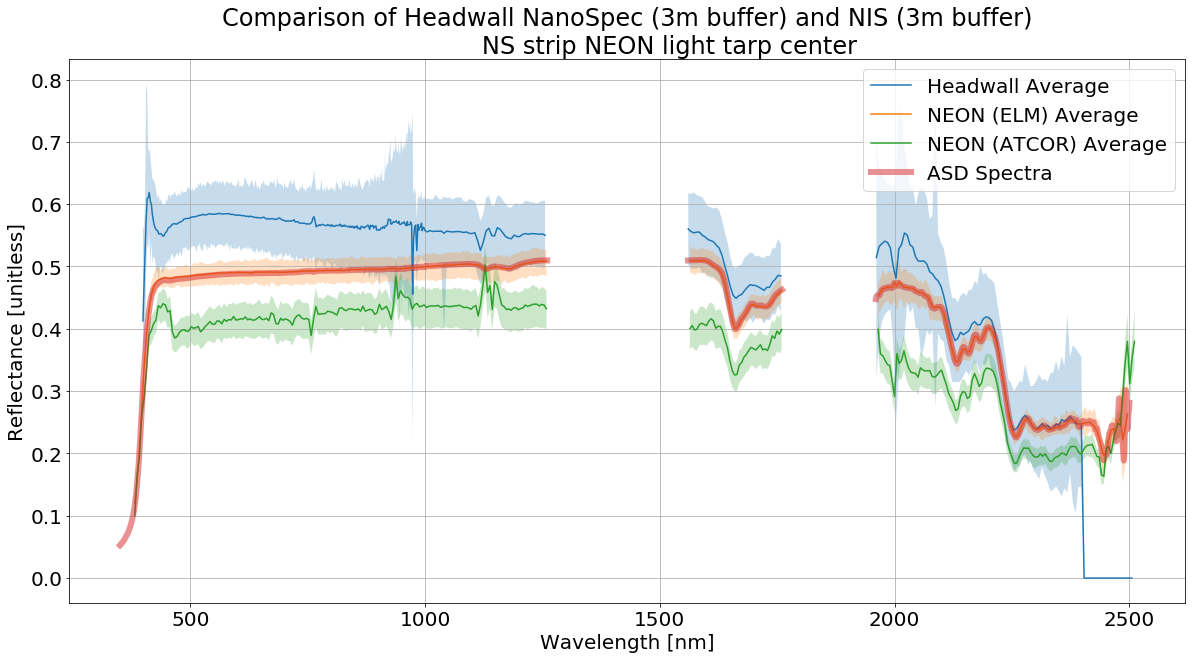

In [20]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)
plt.plot(neon_wav_atcor, neon_mean_ma_atcor, label='NEON (ATCOR) Average')
plt.fill_between(neon_wav_atcor, neon_min_ma_atcor, neon_max_ma_atcor, alpha=0.25)

# ASD spectra
plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

# do the same for dark tarp

In [21]:
## use the shapefile
pt_index = 1 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)


## do the extraction
neon_sub_cube_atcor, neon_arrs_atcor = extract_from_NEON((xarr_NEON_atcor, x_neon_atcor, y_neon_atcor), pt_df_neon)
neon_sub_cube, neon_arrs = extract_from_NEON_ENVI((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall((xarr_VNIR, x_vnir, y_vnir), 
                                                            (xarr_SWIR, x_swir, y_swir),
                                                            pt_df_hw)

neon_wav_atcor, full_neon_atcor = neon_arrs_atcor
neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

neon_mean_atcor = np.nanmean(full_neon_atcor, axis=1)
neon_max_atcor = np.nanmax(full_neon_atcor, axis=1)
neon_min_atcor = np.nanmin(full_neon_atcor, axis=1)

## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_neon_atcor = np.where(((neon_wav_atcor > 1260) & (neon_wav_atcor < 1560)) | ((neon_wav_atcor > 1760) & (neon_wav_atcor < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))


hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

neon_mean_ma_atcor = neon_mean_atcor.copy()
neon_mean_ma_atcor[bad_neon_atcor] = np.nan
neon_max_ma_atcor = neon_max_atcor.copy()
neon_max_ma_atcor[bad_neon_atcor] = np.nan
neon_min_ma_atcor = neon_min_atcor.copy()
neon_min_ma_atcor[bad_neon_atcor] = np.nan

asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')

## mask the water vapor features
asd_wav = asd1.wavelength.values
asd_refl = asd1.refl.values
bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
asd_refl[bad_asd] = np.nan

(66, 65, 270) (65, 65, 270)
(65, 65, 270) (65, 65, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:169: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: All-NaN slice encountered
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: All-NaN slice encountered


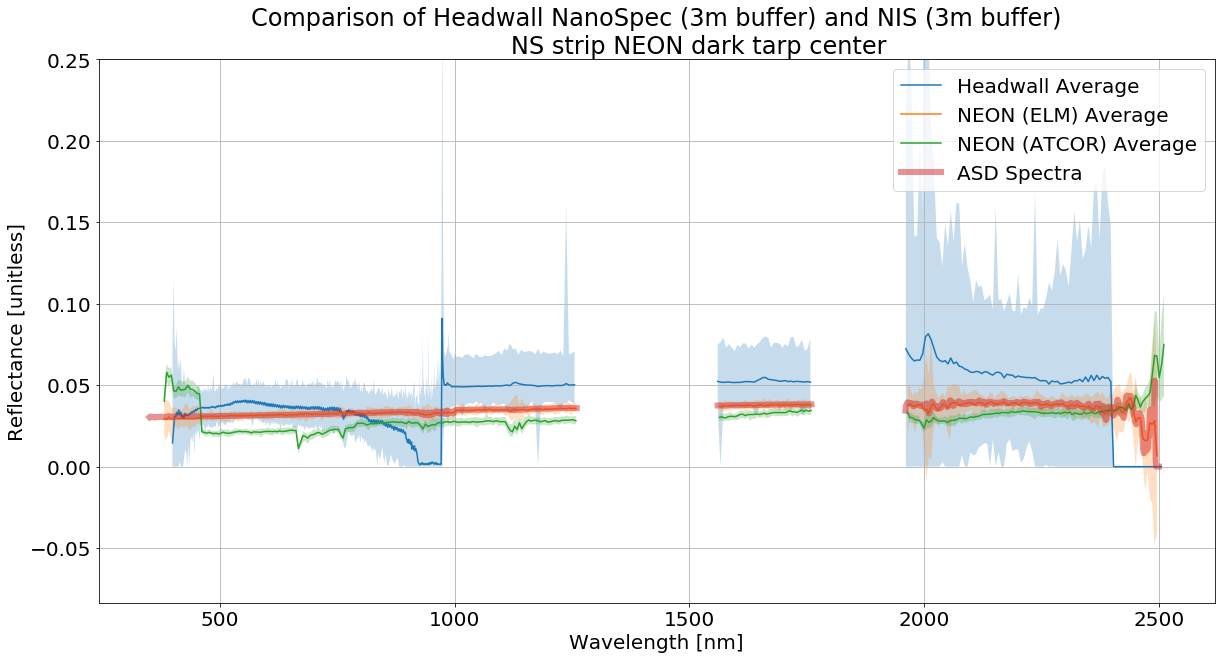

In [22]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)
plt.plot(neon_wav_atcor, neon_mean_ma_atcor, label='NEON (ATCOR) Average')
plt.fill_between(neon_wav_atcor, neon_min_ma_atcor, neon_max_ma_atcor, alpha=0.25)

# ASD spectra
plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.ylim(top=0.25)
plt.show()